In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50, densenet121, vgg16
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
import glob

In [2]:
# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["TORCH_DYNAMO_DISABLE"] = "1"

In [3]:
# 1. Thiết lập đường dẫn
organized_data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
nih_data_dir = "/kaggle/input/data"
nih_metadata_path = os.path.join(nih_data_dir, "Data_Entry_2017.csv")
chest_xray_data = "/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset"
covid19_pneumonia = "/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset"
pneumonia_chest_xrays = "/kaggle/input/pneumonia-chest-xrays/Pneumonia_Chest_Xray"
tb_chest = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

# 2. Chuẩn bị dữ liệu NIH
print("Đang chuẩn bị dataset NIH...")
nih_df = pd.read_csv(nih_metadata_path)
nih_df = nih_df[nih_df['Finding Labels'].isin(['No Finding', 'Pneumonia'])]
nih_df['label'] = nih_df['Finding Labels'].apply(lambda x: 'NORMAL' if x == 'No Finding' else 'PNEUMONIA')
nih_df['class'] = nih_df['Finding Labels'].apply(lambda x: 0 if x == 'No Finding' else 1)

# Cân bằng dữ liệu NIH
normal_df = nih_df[nih_df['label'] == 'NORMAL'].sample(n=5000, random_state=42)
pneumonia_df = nih_df[nih_df['label'] == 'PNEUMONIA']
nih_df = pd.concat([normal_df, pneumonia_df])
print(f"NIH dataset - Phân bố lớp sau cân bằng:\n{nih_df['label'].value_counts()}")

# Tìm đường dẫn ảnh NIH
def get_full_image_path(image_filename, image_subdirs):
    for subdir in image_subdirs:
        path1 = os.path.join(subdir, image_filename)
        path2 = os.path.join(subdir, "images", image_filename)
        if os.path.exists(path1):
            return path1
        elif os.path.exists(path2):
            return path2
    return None

nih_image_dirs = glob.glob(os.path.join(nih_data_dir, "images_*"))
nih_df['image_path'] = nih_df['Image Index'].apply(lambda x: get_full_image_path(x, nih_image_dirs))
nih_df = nih_df.dropna(subset=['image_path'])


Đang chuẩn bị dataset NIH...
NIH dataset - Phân bố lớp sau cân bằng:
label
NORMAL       5000
PNEUMONIA     322
Name: count, dtype: int64


In [4]:
# 3. Chuẩn bị dữ liệu từ các dataset khác
def collect_image_paths_from_dir(root_dir):
    collected_paths = []
    labels = []
    subdirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    label_map = {}
    for subdir in subdirs:
        lower_name = subdir.lower()
        if "normal" in lower_name:
            label_map[subdir] = "NORMAL"
        elif "pneumonia" in lower_name:
            label_map[subdir] = "PNEUMONIA"
    for subdir, label in label_map.items():
        full_dir = os.path.join(root_dir, subdir)
        image_files = glob.glob(os.path.join(full_dir, "*.jpg")) + \
                      glob.glob(os.path.join(full_dir, "*.jpeg")) + \
                      glob.glob(os.path.join(full_dir, "*.png"))
        collected_paths.extend(image_files)
        labels.extend([label] * len(image_files))
    return pd.DataFrame({'image_path': collected_paths, 'label': labels})

other_datasets_df = pd.DataFrame()
for dataset_path in [chest_xray_data, covid19_pneumonia, pneumonia_chest_xrays, tb_chest]:
    df = collect_image_paths_from_dir(dataset_path)
    other_datasets_df = pd.concat([other_datasets_df, df], ignore_index=True)
other_datasets_df['class'] = other_datasets_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1)
print(f"Dataset khác - Phân bố lớp:\n{other_datasets_df['label'].value_counts()}")

# Chia tập dữ liệu khác
other_train, other_test = train_test_split(other_datasets_df, test_size=0.4, stratify=other_datasets_df['label'], random_state=42)
other_test, other_val = train_test_split(other_test, test_size=0.5, stratify=other_test['label'], random_state=42)

Dataset khác - Phân bố lớp:
label
PNEUMONIA    10859
NORMAL        8979
Name: count, dtype: int64


In [5]:
# 4. Định nghĩa XRayDataset
class XRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['class']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Định nghĩa biến đổi ảnh
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.1, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# 5. Tạo DataLoader
def setup_dataloaders(batch_size=64):
    org_train_df = collect_image_paths_from_dir(os.path.join(organized_data_dir, "train"))
    org_val_df = collect_image_paths_from_dir(os.path.join(organized_data_dir, "val"))
    org_test_df = collect_image_paths_from_dir(os.path.join(organized_data_dir, "test"))
    org_train_df['class'] = org_train_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1)
    org_val_df['class'] = org_val_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1)
    org_test_df['class'] = org_test_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1)

    train_df = pd.concat([org_train_df, nih_df, other_train], ignore_index=True)
    val_df = pd.concat([org_val_df, other_val], ignore_index=True)
    test_df = pd.concat([org_test_df, other_test], ignore_index=True)

    train_dataset = XRayDataset(train_df, transform=train_transform)
    val_dataset = XRayDataset(val_df, transform=val_transform)
    test_dataset = XRayDataset(test_df, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [7]:
# 6. Kiểm tra sự mất cân bằng dữ liệu
def check_data_imbalance(df, label_column='label', plot=True, verbose=True):
    try:
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input 'df' phải là pandas DataFrame.")
        if label_column not in df.columns:
            raise ValueError(f"Cột '{label_column}' không tìm thấy trong DataFrame.")
        
        class_counts = df[label_column].value_counts()
        total_samples = len(df)
        class_ratios = (class_counts / total_samples * 100).round(2)
        max_count = class_counts.max()
        min_count = class_counts.min()
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
        
        if verbose:
            print("\n=== Phân tích mất cân bằng dữ liệu ===")
            print(f"Tổng số mẫu: {total_samples}")
            print("\nSố lượng theo lớp:")
            for cls, count in class_counts.items():
                print(f"  {cls}: {count} mẫu ({class_ratios[cls]}%)")
            print(f"\nTỷ lệ mất cân bằng (lớp đa số/lớp thiểu số): {imbalance_ratio:.2f}")
            if imbalance_ratio > 2:
                print("Cảnh báo: Dữ liệu mất cân bằng đáng kể (tỷ lệ > 2). Cân nhắc kỹ thuật cân bằng.")
            else:
                print("Dữ liệu tương đối cân bằng (tỷ lệ <= 2).")
        
        if plot:
            plt.figure(figsize=(8, 6))
            sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
            plt.title('Phân bố lớp')
            plt.xlabel('Lớp')
            plt.ylabel('Số lượng mẫu')
            for i, count in enumerate(class_counts.values):
                plt.text(i, count + 0.01 * max_count, str(count), ha='center', va='bottom')
            plt.tight_layout()
            plt.show()
        
        return {
            'class_counts': class_counts.to_dict(),
            'class_ratios': class_ratios.to_dict(),
            'imbalance_ratio': imbalance_ratio,
            'total_samples': total_samples
        }
    
    except Exception as e:
        print(f"Lỗi khi kiểm tra mất cân bằng dữ liệu: {e}")
        return None

In [8]:
# 7. Kiểm tra DataLoader
def inspect_dataloaders(train_loader, val_loader, test_loader, num_samples=3):
    try:
        print("\n=== Kích thước dataset ===")
        print(f"Tập huấn luyện: {len(train_loader.dataset)} mẫu")
        print(f"Tập validation: {len(val_loader.dataset)} mẫu")
        print(f"Tập kiểm tra: {len(test_loader.dataset)} mẫu")
        
        print("\n=== Phân bố lớp ===")
        for name, loader in [("Huấn luyện", train_loader), ("Validation", val_loader), ("Kiểm tra", test_loader)]:
            df = loader.dataset.df
            print(f"\nTập {name}:")
            check_data_imbalance(df, label_column='label', plot=True, verbose=True)
        
        def plot_samples(loader, name, num_samples):
            images, labels = next(iter(loader))
            images = images[:num_samples]
            labels = labels[:num_samples]
            plt.figure(figsize=(15, 5))
            for i in range(num_samples):
                img = images[i].permute(1, 2, 0).numpy()
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img)
                plt.title(f"{'PNEUMONIA' if labels[i].item() == 1 else 'NORMAL'}")
                plt.axis('off')
            plt.suptitle(f"Mẫu từ tập {name}")
            plt.tight_layout()
            plt.show()
        
        print("\n=== Mẫu ảnh ===")
        plot_samples(train_loader, "Huấn luyện", num_samples)
        plot_samples(val_loader, "Validation", num_samples)
        plot_samples(test_loader, "Kiểm tra", num_samples)
        
        print("\n=== Thuộc tính ảnh ===")
        for name, loader in [("Huấn luyện", train_loader), ("Validation", val_loader), ("Kiểm tra", test_loader)]:
            images, labels = next(iter(loader))
            print(f"\nTập {name}:")
            print(f"  Kích thước ảnh: {images.shape}")
            print(f"  Phạm vi giá trị pixel: [{images.min().item():.4f}, {images.max().item():.4f}]")
            print(f"  Kích thước nhãn: {labels.shape}")
            print(f"  Nhãn duy nhất: {np.unique(labels.numpy())}")
    
    except Exception as e:
        print(f"Lỗi khi kiểm tra dataloader: {e}")
        print("Vui lòng đảm bảo train_loader, val_loader, test_loader được định nghĩa đúng.")


In [33]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, densenet121

class CNNBinaryClassifier(nn.Module):
    def __init__(self, model_type='resnet18', pretrained=True):
        super(CNNBinaryClassifier, self).__init__()
        self.model_type = model_type.lower()
        self.pretrained = pretrained
        self.features = None

        # Khởi tạo mô hình dựa trên model_type
        if self.model_type == 'resnet18':
            self.cnn = resnet18(pretrained=pretrained)
            num_ftrs = self.cnn.fc.in_features
            self.cnn.fc = nn.Linear(num_ftrs, 1)
            self.grad_layer = 'layer4'
        elif self.model_type == 'densenet121':
            self.cnn = densenet121(pretrained=pretrained)
            num_ftrs = self.cnn.classifier.in_features
            self.cnn.classifier = nn.Linear(num_ftrs, 1)
            self.grad_layer = 'norm5' 
        elif self.model_type == 'custom':
            self.cnn = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten(),
                nn.Linear(512, 1)
            )
            self.grad_layer = 'conv4'  
        else:
            raise ValueError(f"model_type '{model_type}' không được hỗ trợ. Chọn từ: resnet18, densenet121, custom")

        if pretrained and self.model_type != 'custom':
            for param in self.cnn.parameters():
                param.requires_grad = False
            # Mở khóa tầng cuối và layer Grad-CAM
            if self.model_type == 'resnet18':
                for param in self.cnn.layer4.parameters():
                    param.requires_grad = True
                for param in self.cnn.fc.parameters():
                    param.requires_grad = True
            elif self.model_type == 'densenet121':
                for param in self.cnn.features.norm5.parameters():
                    param.requires_grad = True
                for param in self.cnn.classifier.parameters():
                    param.requires_grad = True
        elif self.model_type == 'custom':
            for param in self.cnn.parameters():
                param.requires_grad = True

        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            if output is not None and isinstance(output, torch.Tensor):
                self.features = output
            else:
                print(f"Cảnh báo: Output của layer {self.grad_layer} không hợp lệ: {output}")

        # Đăng ký hook cho layer cụ thể
        if self.model_type in ['resnet18', 'resnet50']:
            self.cnn.layer4.register_forward_hook(forward_hook)
            for param in self.cnn.layer4.parameters():
                param.requires_grad = True
        elif self.model_type == 'densenet121':
            self.cnn.features.norm5.register_forward_hook(forward_hook) 
            for param in self.cnn.features.norm5.parameters():
                param.requires_grad = True
        elif self.model_type == 'vgg16':
            self.cnn.features[-1].register_forward_hook(forward_hook) 
            for param in self.cnn.features[-1].parameters():
                param.requires_grad = True
        elif self.model_type == 'custom':
            self.cnn[-4].register_forward_hook(forward_hook)
            for param in self.cnn[-4].parameters():
                param.requires_grad = True
        else:
            raise ValueError(f"Không thể đăng ký hook cho model_type '{self.model_type}'")

    def forward(self, x):
        logits = self.cnn(x)
        return torch.sigmoid(logits), logits

In [10]:
# 9. Callbacks
class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_auc', mode='max'):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_value = -float('inf') if mode == 'max' else float('inf')
    
    def __call__(self, epoch, model, logs):
        current = logs.get(self.monitor)
        if (self.mode == 'max' and current > self.best_value) or (self.mode == 'min' and current < self.best_value):
            self.best_value = current
            torch.save(model.state_dict(), self.filepath)
            print(f"Đã lưu checkpoint tại epoch {epoch+1} với {self.monitor}: {current:.4f}")

class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=7, restore_best_weights=True):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_value = float('inf')
        self.best_weights = None
        self.counter = 0
    
    def __call__(self, epoch, model, logs):
        current = logs.get(self.monitor)
        if current < self.best_value:
            self.best_value = current
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Dừng sớm tại epoch {epoch+1}")
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        return False

class ReduceLROnPlateau:
    def __init__(self, monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6):
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.counter = 0
        self.best_value = float('inf')
    
    def __call__(self, epoch, optimizer, logs):
        current = logs.get(self.monitor)
        if current < self.best_value:
            self.best_value = current
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                for param_group in optimizer.param_groups:
                    new_lr = max(param_group['lr'] * self.factor, self.min_lr)
                    param_group['lr'] = new_lr
                    print(f"Giảm learning rate xuống {new_lr:.6f}")
                self.counter = 0

In [11]:
def inspect_and_fix_state_dict(model, checkpoint_path, device='cpu'):
    """
    Kiểm tra và sửa state_dict của checkpoint để tải vào mô hình.
    
    Args:
        model: Mô hình PyTorch.
        checkpoint_path: Đường dẫn đến file checkpoint.
        device: Thiết bị để tải checkpoint.
    
    Returns:
        state_dict đã được sửa (hoặc nguyên bản nếu không cần sửa).
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
    
    print("Các khóa trong checkpoint:")
    for key in list(state_dict.keys())[:10]:  # In 10 khóa đầu tiên
        print(key)
    print("Các khóa trong mô hình:")
    for key in list(model.state_dict().keys())[:10]:
        print(key)
    
    # Loại bỏ tiền tố 'module.' nếu có
    if any(key.startswith('module.') for key in state_dict.keys()):
        print("Loại bỏ tiền tố 'module.' từ state_dict")
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    
    # Ánh xạ các khóa nếu cần
    key_mapping = {
        'features.conv0.weight': 'cnn.features.conv0.weight',
        'features.norm0.weight': 'cnn.features.norm0.weight',
        'features.norm0.bias': 'cnn.features.norm0.bias',
        'features.norm0.running_mean': 'cnn.features.norm0.running_mean',
        'features.norm0.running_var': 'cnn.features.norm0.running_var',
        'classifier.weight': 'cnn.classifier.weight',
        'classifier.bias': 'cnn.classifier.bias',
    }
    
    model_dict = model.state_dict()
    new_state_dict = {key_mapping.get(k, k): v for k, v in state_dict.items() if key_mapping.get(k, k) in model_dict}
    model_dict.update(new_state_dict)
    
    return model_dict

In [24]:
# 10. Hàm tính Grad-CAM
def get_gradcam_heatmap(model, image, class_idx=0, device='cuda'):
    try:
        model.eval()
        image = image.unsqueeze(0).to(device)
        if not image.requires_grad:
            image.requires_grad_(True)
        
        print(f"Kích thước ảnh đầu vào: {image.shape}")
        
        # Forward pass
        sigmoid_outputs, logits = model(image)
        print(f"Kích thước sigmoid outputs: {sigmoid_outputs.shape}, Giá trị: {sigmoid_outputs}")
        print(f"Kích thước logits: {logits.shape}, Giá trị: {logits}")
        
        if model.features is None:
            raise ValueError("Feature maps không được ghi lại. Kiểm tra forward hook.")
        
        features = model.features
        print(f"Kích thước feature maps: {features.shape}")
        
        model.zero_grad()
        target_logit = logits[:, class_idx]
        target_logit.backward()
        
        # Kiểm tra gradient của feature maps
        gradients = features.grad
        if gradients is None:
            print("Lỗi: Gradient của feature maps là None. Kiểm tra layer và requires_grad.")
            return np.zeros((7, 7))
        
        print(f"Kích thước gradients: {gradients.shape}, Min/max: {gradients.min()}, {gradients.max()}")
        
        # Tính trọng số
        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        print(f"Kích thước weights: {weights.shape}, Min/max: {weights.min()}, {weights.max()}")
        
        # Tính heatmap
        heatmap = torch.sum(weights * features, dim=1).squeeze()
        heatmap = torch.relu(heatmap)
        print(f"Kích thước heatmap trước chuẩn hóa: {heatmap.shape}, Min/max: {heatmap.min()}, {heatmap.max()}")
        
        # Chuẩn hóa heatmap
        heatmap_max = torch.max(heatmap)
        if heatmap_max > 0:
            heatmap = heatmap / (heatmap_max + 1e-8)
        else:
            print("Lỗi: Heatmap toàn số 0. Kiểm tra feature maps và gradients.")
            return np.zeros((7, 7))
        
        heatmap = heatmap.detach().cpu().numpy()
        print(f"Kích thước heatmap cuối: {heatmap.shape}, Min/max: {heatmap.min()}, {heatmap.max()}")
        
        return heatmap
    
    except Exception as e:
        print(f"Lỗi khi tính Grad-CAM: {e}")
        return np.zeros((7, 7))

# 11. Hàm vẽ Grad-CAM
def visualize_gradcam(image, heatmap, title="Grad-CAM", alpha=0.6):
    try:
        image = image.cpu().numpy().transpose(1, 2, 0)
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
        
        heatmap = np.uint8(255 * heatmap)
        heatmap = Image.fromarray(heatmap).resize((image.shape[1], image.shape[0]), resample=Image.BILINEAR)
        heatmap = np.array(heatmap) / 255.0
        
        heatmap_color = plt.cm.jet(heatmap)[:, :, :3]
        superimposed_img = heatmap_color * alpha + image * (1 - alpha)
        superimposed_img = superimposed_img.clip(0, 1)
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Ảnh gốc")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("Heatmap Grad-CAM")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(superimposed_img)
        plt.title("Ảnh chồng lấn")
        plt.axis('off')
        plt.suptitle(title)
        plt.show()
    
    except Exception as e:
        print(f"Lỗi khi vẽ Grad-CAM: {e}")
        plt.figure()
        plt.imshow(image)
        plt.title("Ảnh gốc (Vẽ thất bại)")
        plt.axis('off')
        plt.show()

In [13]:
# 12. Hàm huấn luyện
def train_model(model, train_loader, val_loader, epochs=30):
    model = model.to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    criterion = nn.BCELoss()
    
    callbacks = [
        ModelCheckpoint('pneumonia_cnn_model.pth', monitor='val_auc', mode='max'),
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]
    
    history = {'loss': [], 'accuracy': [], 'auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_score = []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            sigmoid_outputs, _ = model(images)
            loss = criterion(sigmoid_outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (sigmoid_outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy().flatten())
            y_score.extend(sigmoid_outputs.cpu().detach().numpy().flatten())
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total if total > 0 else 0.0
        try:
            epoch_auc = roc_auc_score(y_true, y_score) if len(set(y_true)) > 1 else 0.0
        except ValueError as e:
            print(f"Cảnh báo: Tính AUC thất bại cho tập huấn luyện: {e}")
            epoch_auc = 0.0
        
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        history['auc'].append(epoch_auc)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_y_true = []
        val_y_score = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().view(-1, 1)
                sigmoid_outputs, _ = model(images)
                loss = criterion(sigmoid_outputs, labels)
                val_loss += loss.item()
                predicted = (sigmoid_outputs > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                val_y_true.extend(labels.cpu().numpy().flatten())
                val_y_score.extend(sigmoid_outputs.cpu().detach().numpy().flatten())
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        try:
            val_auc = roc_auc_score(val_y_true, val_y_score) if len(set(val_y_true)) > 1 else 0.0
        except ValueError as e:
            print(f"Cảnh báo: Tính AUC thất bại cho tập validation: {e}")
            val_auc = 0.0
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        history['val_auc'].append(val_auc)
        
        print(f"loss: {epoch_loss:.4f} - accuracy: {epoch_acc:.4f} - auc: {epoch_auc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f} - val_auc: {val_auc:.4f}")
        
        logs = {
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            'auc': epoch_auc,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_auc': val_auc
        }
        for callback in callbacks:
            if isinstance(callback, EarlyStopping):
                if callback(epoch, model, logs):
                    break
            elif isinstance(callback, ReduceLROnPlateau):
                callback(epoch, optimizer, logs)
            else:
                callback(epoch, model, logs)
    
    return history

# 13. Hàm đánh giá
def evaluate_model(model, test_loader, class_names=['NORMAL', 'PNEUMONIA']):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_score = []
    
    criterion = nn.BCELoss()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            sigmoid_outputs, _ = model(images)
            loss = criterion(sigmoid_outputs, labels)
            test_loss += loss.item()
            predicted = (sigmoid_outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy().flatten())
            y_pred.extend(predicted.cpu().numpy().flatten())
            y_score.extend(sigmoid_outputs.cpu().numpy().flatten())
    
    test_loss /= len(test_loader)
    test_acc = correct / total if total > 0 else 0.0
    try:
        test_auc = roc_auc_score(y_true, y_score) if len(set(y_true)) > 1 else 0.0
    except ValueError as e:
        print(f"Cảnh báo: Tính AUC thất bại cho tập kiểm tra: {e}")
        test_auc = 0.0
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Ma trận nhầm lẫn')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()

    print("\n=== Chỉ số phân loại ===")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")

In [26]:
def predict_and_visualize_gradcam(image_path, model_path='/kaggle/working/pneumonia_cnn_model.pth', device='cuda', class_names=['NORMAL', 'PNEUMONIA']):
    try:
        device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Khởi tạo mô hình
        model = CNNBinaryClassifier(model_type='resnet18', pretrained=False).to(device)
        
        # === PHẦN CẦN SỬA ===
        # Sử dụng hàm phụ để kiểm tra và sửa state_dict
        fixed_state_dict = inspect_and_fix_state_dict(model, model_path, device)
        model.load_state_dict(fixed_state_dict, strict=False)
        # === KẾT THÚC PHẦN CẦN SỬA ===
        
        model.eval()
        print(f"Đã tải mô hình từ {model_path}")
        
        # Chuẩn bị ảnh đầu vào
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        image_tensor_input = image_tensor.unsqueeze(0).to(device)
        
        # Dự đoán
        with torch.no_grad():
            sigmoid_outputs, _ = model(image_tensor_input)
            probability = sigmoid_outputs.item()
            predicted = 1 if probability > 0.5 else 0
            predicted_label = class_names[predicted]
        
        result = {
            'label': predicted_label,
            'probability': probability,
            'message': f"Dự đoán: {predicted_label} với xác suất {probability:.4f}"
        }
        print(result['message'])
        
        # Tính và vẽ Grad-CAM
        heatmap = get_gradcam_heatmap(model, image_tensor, class_idx=predicted, device=device)
        visualize_gradcam(image_tensor, heatmap, title=f"Grad-CAM cho {predicted_label}")
        
        return result
    
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh hoặc Grad-CAM: {e}")
        return {
            'label': None,
            'probability': None,
            'message': f"Lỗi: {str(e)}"
        }


=== Kích thước dataset ===
Tập huấn luyện: 22440 mẫu
Tập validation: 3984 mẫu
Tập kiểm tra: 4592 mẫu

=== Phân bố lớp ===

Tập Huấn luyện:

=== Phân tích mất cân bằng dữ liệu ===
Tổng số mẫu: 22440

Số lượng theo lớp:
  NORMAL: 11728 mẫu (52.26%)
  PNEUMONIA: 10712 mẫu (47.74%)

Tỷ lệ mất cân bằng (lớp đa số/lớp thiểu số): 1.09
Dữ liệu tương đối cân bằng (tỷ lệ <= 2).


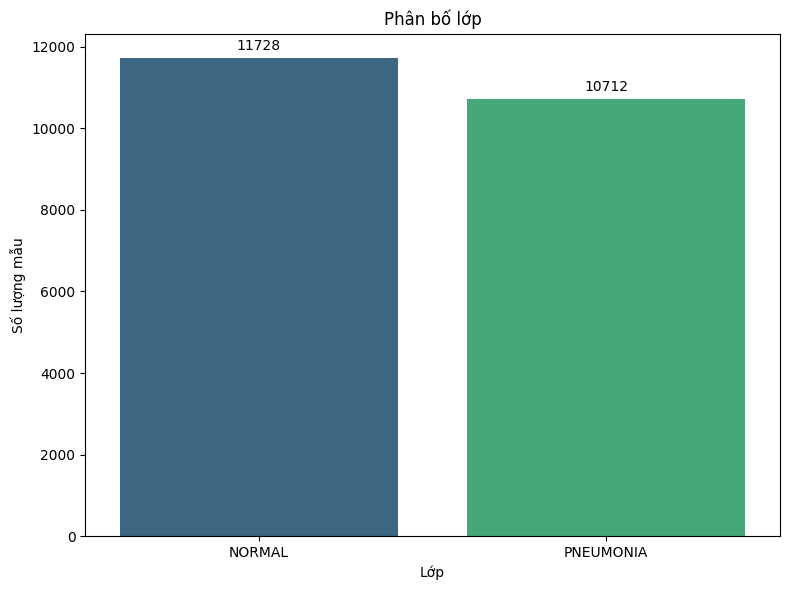


Tập Validation:

=== Phân tích mất cân bằng dữ liệu ===
Tổng số mẫu: 3984

Số lượng theo lớp:
  PNEUMONIA: 2180 mẫu (54.72%)
  NORMAL: 1804 mẫu (45.28%)

Tỷ lệ mất cân bằng (lớp đa số/lớp thiểu số): 1.21
Dữ liệu tương đối cân bằng (tỷ lệ <= 2).


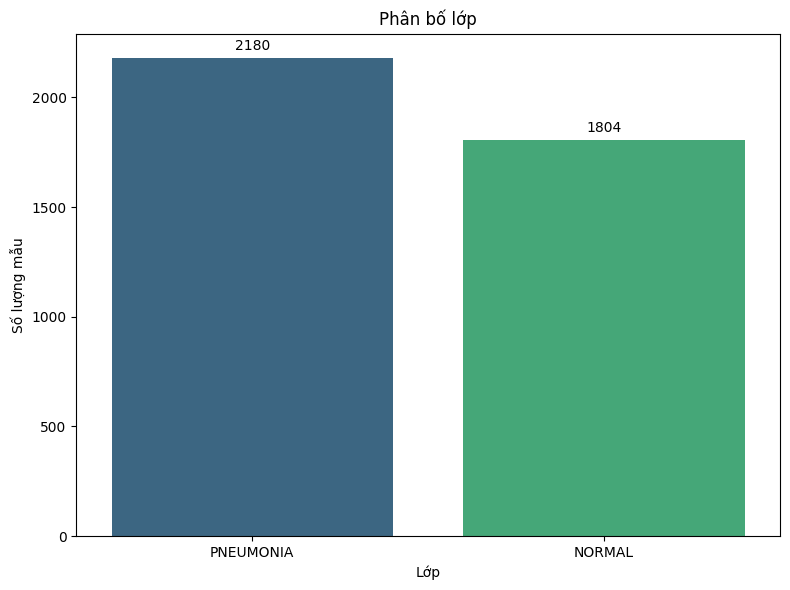


Tập Kiểm tra:

=== Phân tích mất cân bằng dữ liệu ===
Tổng số mẫu: 4592

Số lượng theo lớp:
  PNEUMONIA: 2562 mẫu (55.79%)
  NORMAL: 2030 mẫu (44.21%)

Tỷ lệ mất cân bằng (lớp đa số/lớp thiểu số): 1.26
Dữ liệu tương đối cân bằng (tỷ lệ <= 2).


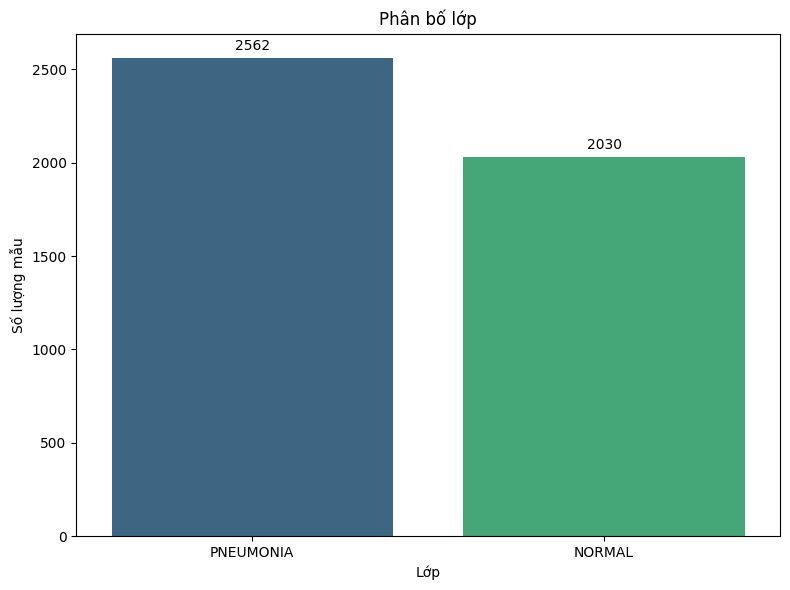


=== Mẫu ảnh ===


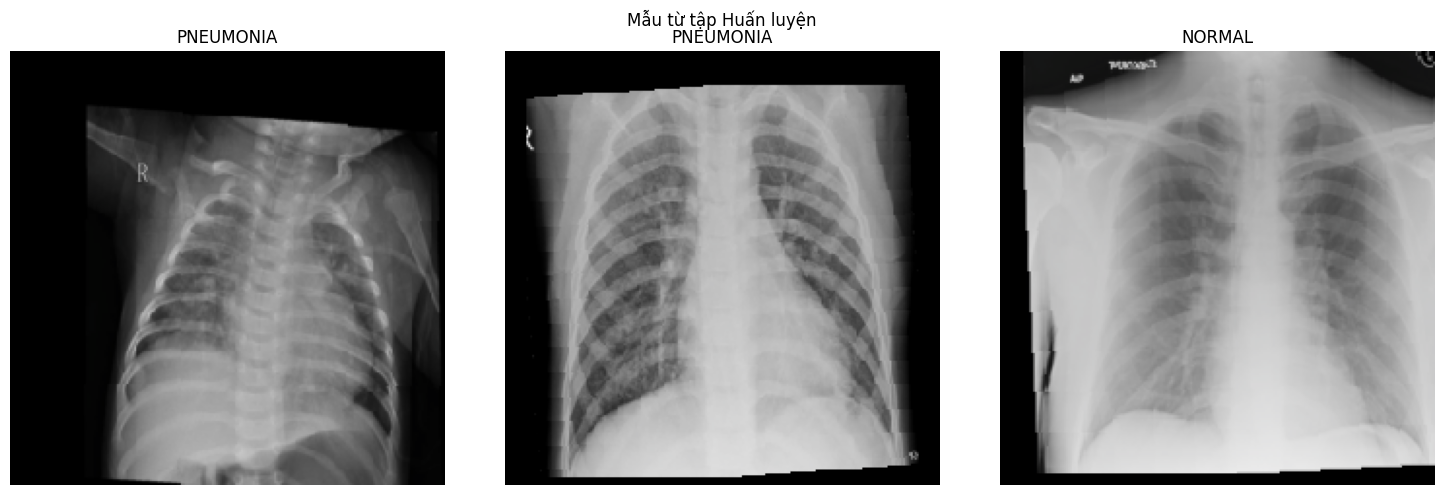

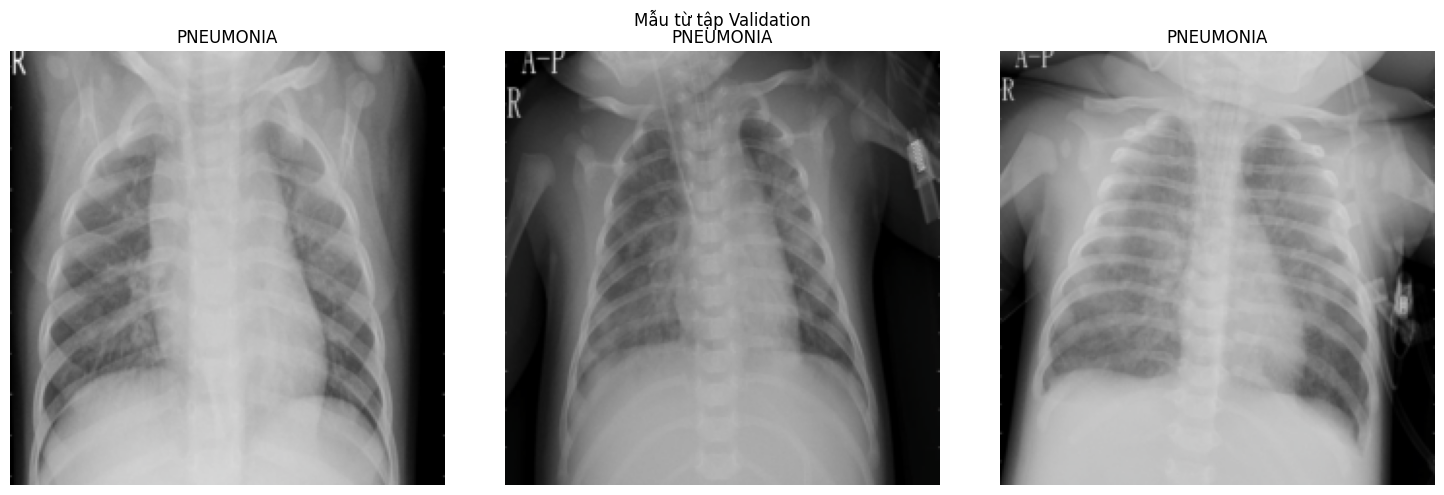

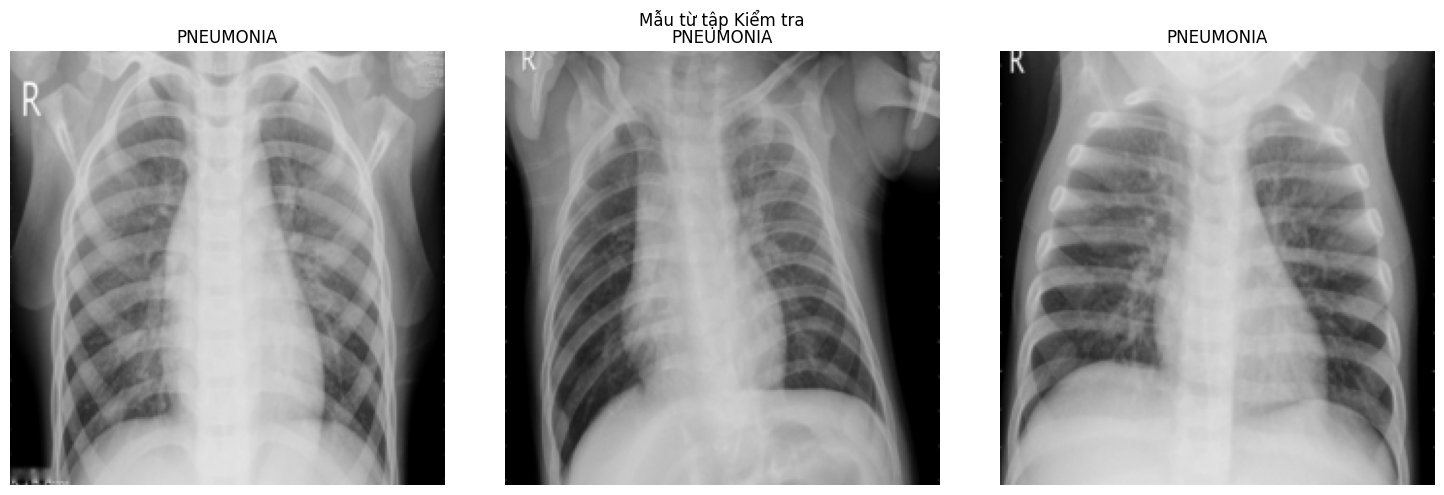


=== Thuộc tính ảnh ===

Tập Huấn luyện:
  Kích thước ảnh: torch.Size([64, 3, 224, 224])
  Phạm vi giá trị pixel: [-2.1179, 2.6400]
  Kích thước nhãn: torch.Size([64])
  Nhãn duy nhất: [0 1]

Tập Validation:
  Kích thước ảnh: torch.Size([64, 3, 224, 224])
  Phạm vi giá trị pixel: [-2.1179, 2.6400]
  Kích thước nhãn: torch.Size([64])
  Nhãn duy nhất: [0 1]

Tập Kiểm tra:
  Kích thước ảnh: torch.Size([64, 3, 224, 224])
  Phạm vi giá trị pixel: [-2.1179, 2.6400]
  Kích thước nhãn: torch.Size([64])
  Nhãn duy nhất: [1]


In [15]:
# 15. Chạy pipeline
batch_size = 64
train_loader, val_loader, test_loader = setup_dataloaders(batch_size)
inspect_dataloaders(train_loader, val_loader, test_loader, num_samples=3)

In [16]:
print("\nTHÔNG TIN CHI TIẾT VỀ DATASET:")
print("-----------------------------")
print(f"Tổng số mẫu huấn luyện: {len(train_loader.dataset)}")
print(f"Tổng số mẫu validation: {len(val_loader.dataset)}")
print(f"Tổng số mẫu kiểm tra: {len(test_loader.dataset)}")


THÔNG TIN CHI TIẾT VỀ DATASET:
-----------------------------
Tổng số mẫu huấn luyện: 22440
Tổng số mẫu validation: 3984
Tổng số mẫu kiểm tra: 4592


# Huấn luyện với mô hình Densenet

In [17]:
model = CNNBinaryClassifier(model_type='densenet121', pretrained=True).to(device)
history = train_model(model, train_loader, val_loader, epochs=30)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 136MB/s] 



Epoch 1/30
loss: 0.1881 - accuracy: 0.9371 - auc: 0.9744 - val_loss: 0.1123 - val_accuracy: 0.9654 - val_auc: 0.9907
Đã lưu checkpoint tại epoch 1 với val_auc: 0.9907

Epoch 2/30
loss: 0.1288 - accuracy: 0.9600 - auc: 0.9845 - val_loss: 0.0915 - val_accuracy: 0.9739 - val_auc: 0.9931
Đã lưu checkpoint tại epoch 2 với val_auc: 0.9931

Epoch 3/30
loss: 0.1172 - accuracy: 0.9632 - auc: 0.9872 - val_loss: 0.0792 - val_accuracy: 0.9767 - val_auc: 0.9945
Đã lưu checkpoint tại epoch 3 với val_auc: 0.9945

Epoch 4/30
loss: 0.1039 - accuracy: 0.9669 - auc: 0.9899 - val_loss: 0.0756 - val_accuracy: 0.9757 - val_auc: 0.9954
Đã lưu checkpoint tại epoch 4 với val_auc: 0.9954

Epoch 5/30
loss: 0.0984 - accuracy: 0.9683 - auc: 0.9913 - val_loss: 0.0694 - val_accuracy: 0.9804 - val_auc: 0.9961
Đã lưu checkpoint tại epoch 5 với val_auc: 0.9961

Epoch 6/30
loss: 0.0912 - accuracy: 0.9691 - auc: 0.9926 - val_loss: 0.0689 - val_accuracy: 0.9777 - val_auc: 0.9967
Đã lưu checkpoint tại epoch 6 với val_auc:

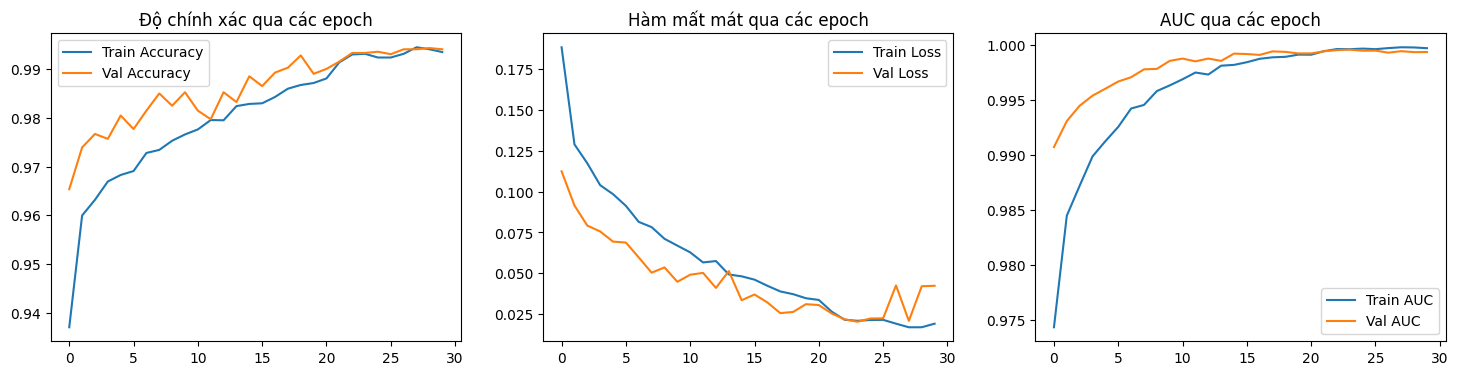

In [18]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Độ chính xác qua các epoch')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Hàm mất mát qua các epoch')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(history['auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Val AUC')
plt.title('AUC qua các epoch')
plt.legend()
plt.show()

Test Loss: 0.0745
Test Accuracy: 0.9911
Test AUC: 0.9988


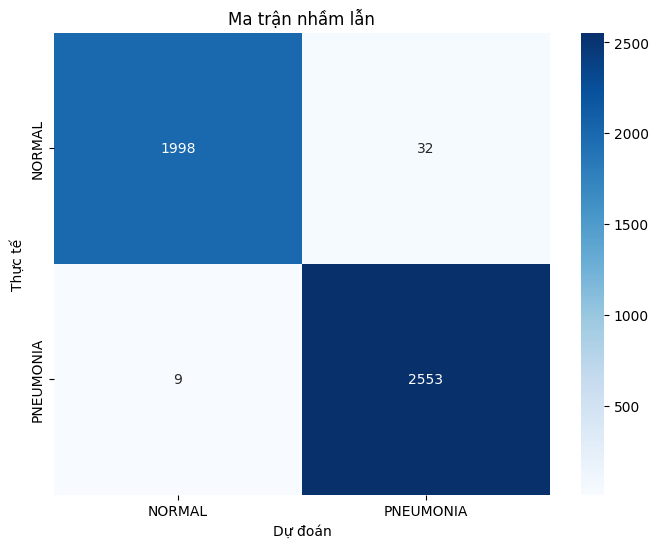


=== Chỉ số phân loại ===
NORMAL:
  Precision: 0.9955
  Recall: 0.9842
  F1-Score: 0.9898
PNEUMONIA:
  Precision: 0.9876
  Recall: 0.9965
  F1-Score: 0.9920


In [19]:
evaluate_model(model, test_loader)

In [ ]:
torch.save(model.state_dict(), 'pneumonia_cnn_denesnet_model.pth')

# Huấn luyện với mô hình Resnet

In [20]:
model = CNNBinaryClassifier(model_type='resnet18', pretrained=True).to(device)
history = train_model(model, train_loader, val_loader, epochs=30)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s] 



Epoch 1/30
loss: 0.1534 - accuracy: 0.9504 - auc: 0.9801 - val_loss: 0.1121 - val_accuracy: 0.9608 - val_auc: 0.9909
Đã lưu checkpoint tại epoch 1 với val_auc: 0.9909

Epoch 2/30
loss: 0.1111 - accuracy: 0.9652 - auc: 0.9881 - val_loss: 0.0870 - val_accuracy: 0.9741 - val_auc: 0.9947
Đã lưu checkpoint tại epoch 2 với val_auc: 0.9947

Epoch 3/30
loss: 0.0971 - accuracy: 0.9695 - auc: 0.9908 - val_loss: 0.0693 - val_accuracy: 0.9789 - val_auc: 0.9964
Đã lưu checkpoint tại epoch 3 với val_auc: 0.9964

Epoch 4/30
loss: 0.0850 - accuracy: 0.9727 - auc: 0.9930 - val_loss: 0.0544 - val_accuracy: 0.9819 - val_auc: 0.9976
Đã lưu checkpoint tại epoch 4 với val_auc: 0.9976

Epoch 5/30
loss: 0.0790 - accuracy: 0.9730 - auc: 0.9945 - val_loss: 0.0626 - val_accuracy: 0.9802 - val_auc: 0.9971

Epoch 6/30
loss: 0.0667 - accuracy: 0.9776 - auc: 0.9960 - val_loss: 0.0506 - val_accuracy: 0.9812 - val_auc: 0.9984
Đã lưu checkpoint tại epoch 6 với val_auc: 0.9984

Epoch 7/30
loss: 0.0615 - accuracy: 0.978

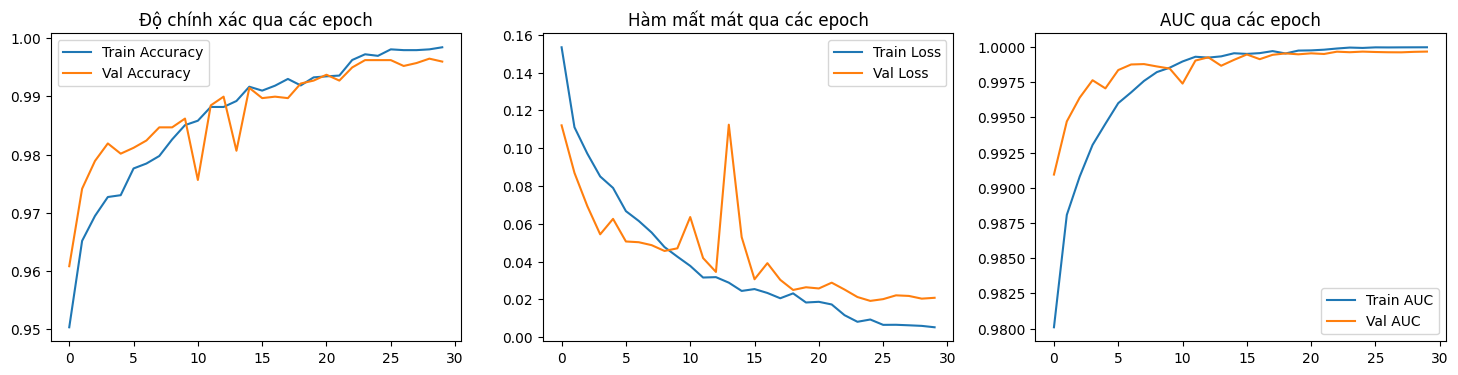

In [21]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Độ chính xác qua các epoch')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Hàm mất mát qua các epoch')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(history['auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Val AUC')
plt.title('AUC qua các epoch')
plt.legend()
plt.show()

Test Loss: 0.0284
Test Accuracy: 0.9956
Test AUC: 0.9995


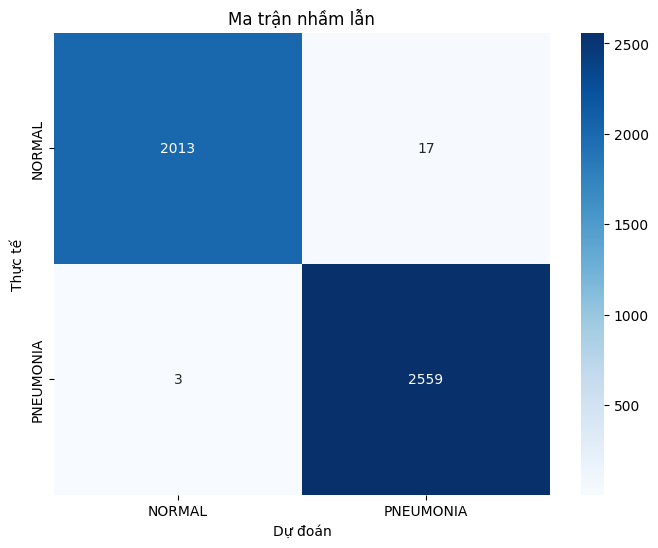


=== Chỉ số phân loại ===
NORMAL:
  Precision: 0.9985
  Recall: 0.9916
  F1-Score: 0.9951
PNEUMONIA:
  Precision: 0.9934
  Recall: 0.9988
  F1-Score: 0.9961


In [22]:
evaluate_model(model, test_loader)

In [23]:
torch.save(model.state_dict(), 'pneumonia_cnn_resnet_model.pth')

# Huấn luyện với mô hình custom CNN

In [28]:
model = CNNBinaryClassifier(model_type='custom', pretrained=False).to(device)
history = train_model(model, train_loader, val_loader, epochs=30)


Epoch 1/30
loss: 0.5645 - accuracy: 0.7070 - auc: 0.7874 - val_loss: 0.5044 - val_accuracy: 0.7176 - val_auc: 0.9209
Đã lưu checkpoint tại epoch 1 với val_auc: 0.9209

Epoch 2/30
loss: 0.3743 - accuracy: 0.8507 - auc: 0.9197 - val_loss: 0.3170 - val_accuracy: 0.8710 - val_auc: 0.9514
Đã lưu checkpoint tại epoch 2 với val_auc: 0.9514

Epoch 3/30
loss: 0.3170 - accuracy: 0.8820 - auc: 0.9408 - val_loss: 0.3027 - val_accuracy: 0.8823 - val_auc: 0.9530
Đã lưu checkpoint tại epoch 3 với val_auc: 0.9530

Epoch 4/30
loss: 0.2885 - accuracy: 0.8957 - auc: 0.9506 - val_loss: 0.2741 - val_accuracy: 0.8911 - val_auc: 0.9670
Đã lưu checkpoint tại epoch 4 với val_auc: 0.9670

Epoch 5/30
loss: 0.2773 - accuracy: 0.9008 - auc: 0.9541 - val_loss: 0.2518 - val_accuracy: 0.9106 - val_auc: 0.9651

Epoch 6/30
loss: 0.2618 - accuracy: 0.9070 - auc: 0.9584 - val_loss: 0.2428 - val_accuracy: 0.9139 - val_auc: 0.9685
Đã lưu checkpoint tại epoch 6 với val_auc: 0.9685

Epoch 7/30
loss: 0.2591 - accuracy: 0.911

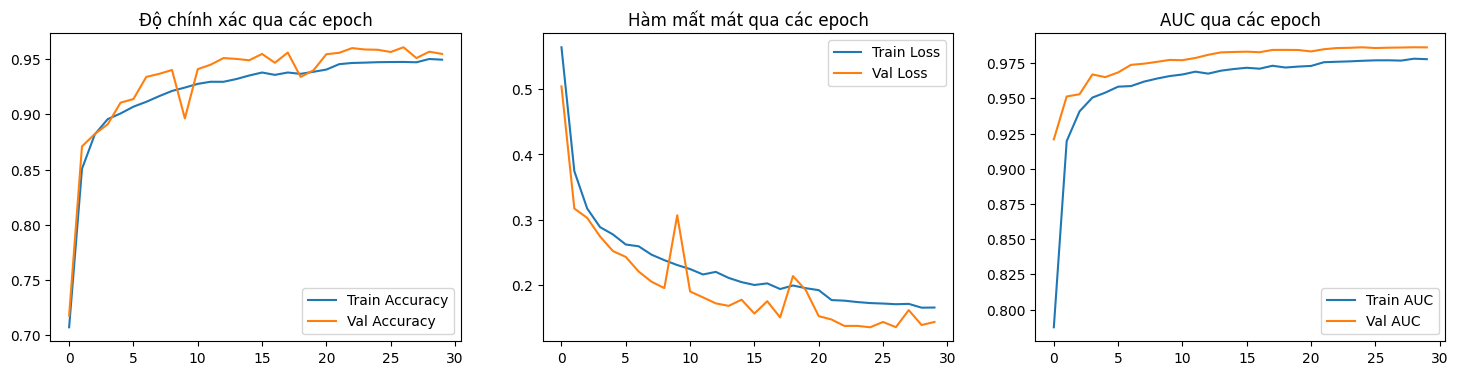

In [29]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Độ chính xác qua các epoch')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Hàm mất mát qua các epoch')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(history['auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Val AUC')
plt.title('AUC qua các epoch')
plt.legend()
plt.show()

Test Loss: 0.1591
Test Accuracy: 0.9517
Test AUC: 0.9807


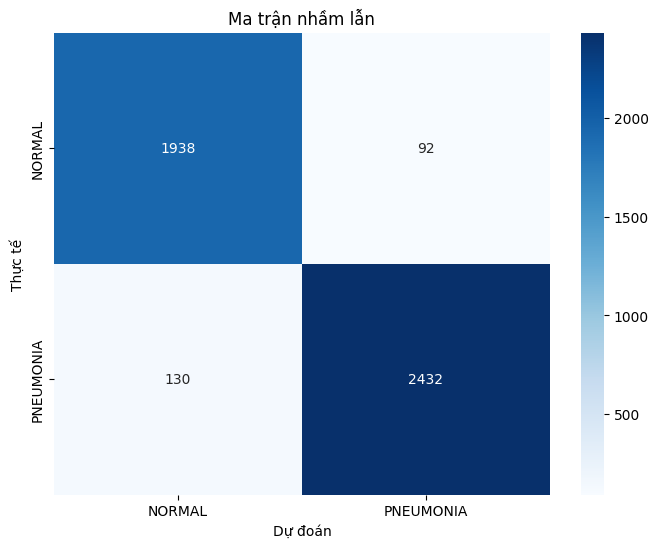


=== Chỉ số phân loại ===
NORMAL:
  Precision: 0.9371
  Recall: 0.9547
  F1-Score: 0.9458
PNEUMONIA:
  Precision: 0.9635
  Recall: 0.9493
  F1-Score: 0.9564


In [30]:
evaluate_model(model, test_loader)

In [31]:
torch.save(model.state_dict(), 'pneumonia_cnn_custom_model.pth')


# Predict và vẽ Grad-CAM

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Các khóa trong checkpoint:
cnn.conv1.weight
cnn.bn1.weight
cnn.bn1.bias
cnn.bn1.running_mean
cnn.bn1.running_var
cnn.bn1.num_batches_tracked
cnn.layer1.0.conv1.weight
cnn.layer1.0.bn1.weight
cnn.layer1.0.bn1.bias
cnn.layer1.0.bn1.running_mean
Các khóa trong mô hình:
cnn.conv1.weight
cnn.bn1.weight
cnn.bn1.bias
cnn.bn1.running_mean
cnn.bn1.running_var
cnn.bn1.num_batches_tracked
cnn.layer1.0.conv1.weight
cnn.layer1.0.bn1.weight
cnn.layer1.0.bn1.bias
cnn.layer1.0.bn1.running_mean
Đã tải mô hình từ /kaggle/working/pneumonia_cnn_resnet_model.pth
Dự đoán: PNEUMONIA với xác suất 1.0000
Kích thước ảnh đầu vào: torch.Size([1, 3, 224, 224])
Kích thước sigmoid outputs: torch.Size([1, 1]), Giá trị: tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Kích thước logits: torch.Size([1, 1]), Giá trị: tensor([[14.4431]], device='cuda:0', grad_fn=<AddmmBackward0>)
Kích thước feature maps: torch.Size([1, 512, 7, 7])
Lỗi khi tính Grad-CAM: index 1 is out of bounds for dimension 1 with size 1


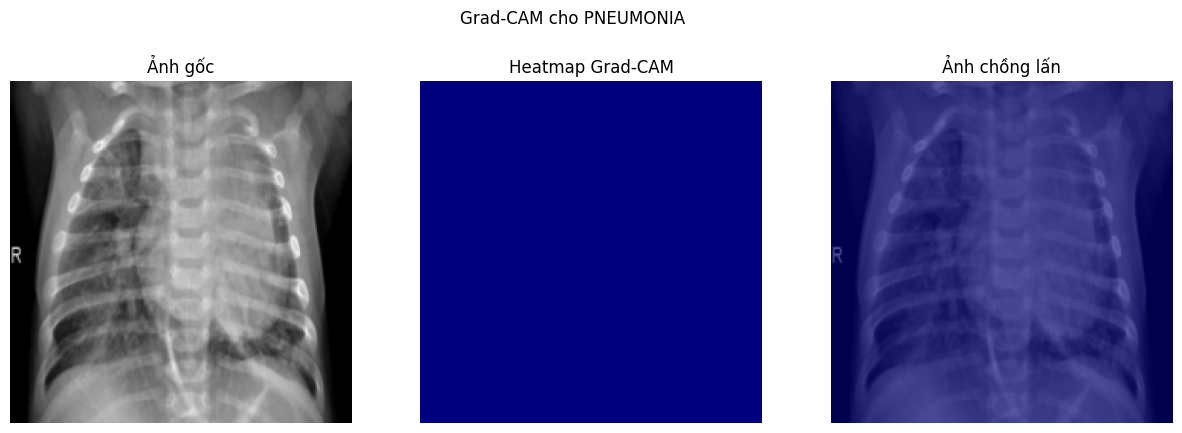

{'label': 'PNEUMONIA', 'probability': 0.9999995231628418, 'message': 'Dự đoán: PNEUMONIA với xác suất 1.0000'}


In [27]:

image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
result = predict_and_visualize_gradcam(image_path, model_path='/kaggle/working/pneumonia_cnn_resnet_model.pth', device=device)
print(result)